# PyTorch/Pyro Implementation

In [1]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from analysis.utils import module_reload
module_reload('analysis')
from analysis.plot_matplotlib import plot_hist
from analysis.mc import BinnedImportanceSamplingIntegrator
from analysis.mc import ImportanceSamplingIntegrator
from analysis import tnp, tnp_mode

# NF example

In [2]:
# Physics
#from analysis.cffi.mg5.lib import mc_batch, mc_batch_sigma
from analysis.import_data import import_true_reco
from typing import Optional, Callable

In [3]:
def print_model_summary(model):
    print(
        'Model: %s\nParameters: %i' %
        (model, sum(p.numel() for p in model.parameters()))
    )

def plot_proposal(dist, n_samples:int=1024, **kwargs):
    samples = dist.sample([n_samples]).detach().cpu().numpy()

    all_max = np.max(samples).max()
    all_min = np.min(samples).min()
    print(f'Using inferred bounds {all_min} to {all_max}')
    
    #print((all_min, all_max))
    dfbase = {}
    for i in range(len(samples.T)):
        dfbase[f'x{i}'] = samples.T[i]

    return plot_hist(pd.DataFrame(dfbase), normalize=True, xlim=(all_min, all_max), xlim_binning=(all_min, all_max), figsize=(8,6), **kwargs)

def plot_integrand(dist, func, n_samples:int=2048, vwindow=None, y_log:bool=False):
    with torch.no_grad():
        samples = dist.sample([n_samples])
        
        samples = samples.cpu()
        results = func(samples).cpu().numpy()
        
        #samples = samples.detach().cpu().numpy()
        
        
        for i in range(len(samples.T)):
            fig, ax = plt.subplots()
            #ax.hist(samples.T[i], alpha=0.4, label=f"Dim {i}", bins=64)
            ax.scatter(x=samples.T[i].numpy(),
                    y=results)
            
            if vwindow is not None:
                if len(vwindow) > 2 and len(vwindow) == len(samples.T):
                    ax.set_ylim(vwindow[i])
                else:
                    ax.set_ylim(vwindow)
                
            ax.set_title('Integrand projection')
            ax.set_xlabel(f"Dim {i}")
            ax.set_ylabel('Integrand value')
            plt.show()
    
    fig, ax = plt.subplots()
    ax.hist(results, bins=32)
    ax.set_xlabel('Integrand value')
    if y_log:
        ax.set_yscale('log')
    ax.set_title('All results')
    
def get_result(dist, func:Callable, n_samples:int=1024, is_nf:bool=True):
    with torch.no_grad():
        samples = dist.sample([n_samples])
        prob = dist.log_prob(samples)
        prob = prob.exp() if is_nf else prob.sum(dim=1).exp()

        res = func(samples)/prob
        
        integral = (1/n_samples * res.sum()).cpu().numpy().item()
        delta = (torch.var(res).cpu()/n_samples).sqrt().numpy().item()
        
    return integral, delta

In [4]:
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.nn import DenseNN
from math import floor

In [5]:
import torch.nn as nn

DEFAULT_MIN_DERIVATIVE = 1e-3

from torch import nn
from torch.nn import functional as F, init


class ResidualBlock(nn.Module):
    """A general-purpose residual block. Works only with 1-dim inputs."""

    def __init__(
        self,
        features,
        context_features,
        activation=F.relu,
        dropout_probability=0.0,
        use_batch_norm=False,
        zero_initialization=True,
    ):
        super().__init__()
        self.activation = activation

        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.batch_norm_layers = nn.ModuleList(
                [nn.BatchNorm1d(features, eps=1e-3) for _ in range(2)]
            )
        if context_features is not None:
            self.context_layer = nn.Linear(context_features, features)
        self.linear_layers = nn.ModuleList(
            [nn.Linear(features, features) for _ in range(2)]
        )
        self.dropout = nn.Dropout(p=dropout_probability)
        if zero_initialization:
            init.uniform_(self.linear_layers[-1].weight, -1e-3, 1e-3)
            init.uniform_(self.linear_layers[-1].bias, -1e-3, 1e-3)

    def forward(self, inputs, context=None):
        temps = inputs
        if self.use_batch_norm:
            temps = self.batch_norm_layers[0](temps)
        temps = self.activation(temps)
        temps = self.linear_layers[0](temps)
        if self.use_batch_norm:
            temps = self.batch_norm_layers[1](temps)
        temps = self.activation(temps)
        temps = self.dropout(temps)
        temps = self.linear_layers[1](temps)
        if context is not None:
            temps = F.glu(torch.cat((temps, self.context_layer(context)), dim=1), dim=1)
        return inputs + temps

class ResidualNet(nn.Module):
    """A general-purpose residual network. Works only with 1-dim inputs."""

    def __init__(
        self,
        in_features,
        out_features,
        hidden_features,
        context_features=None,
        num_blocks=2,
        activation=F.relu,
        dropout_probability=0.0,
        use_batch_norm=False,
        preprocessing=None,
    ):
        super().__init__()
        self.hidden_features = hidden_features
        self.context_features = context_features
        self.preprocessing = preprocessing
        if context_features is not None:
            self.initial_layer = nn.Linear(
                in_features + context_features, hidden_features
            )
        else:
            self.initial_layer = nn.Linear(in_features, hidden_features)
        self.blocks = nn.ModuleList(
            [
                ResidualBlock(
                    features=hidden_features,
                    context_features=context_features,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=use_batch_norm,
                )
                for _ in range(num_blocks)
            ]
        )
        self.final_layer = nn.Linear(hidden_features, out_features)

    def forward(self, inputs, context=None):
        if self.preprocessing is None:
            temps = inputs
        else:
            temps = self.preprocessing(inputs)
        if context is None:
            temps = self.initial_layer(temps)
        else:
            temps = self.initial_layer(torch.cat((temps, context), dim=1))
        for block in self.blocks:
            temps = block(temps, context=context)
            
        outputs = self.final_layer(temps)
        
        b, d = outputs.shape
            # For 2D data, reshape transform_params from Bx(D*?) to BxDx?
        outputs = outputs.reshape(b, d, -1)
        
        return outputs

def transform_net_create_fn(in_features, out_features, init_identity:bool=True,
                            activation=nn.ReLU, dropout_probability:float=0.,
                            num_blocks:int=2, num_context_channels:Optional[int]=None,
                            num_hidden_channels:int=256):
    net = ResidualNet(
        in_features=in_features,
        out_features=out_features,
        context_features=num_context_channels,
        hidden_features=num_hidden_channels,
        num_blocks=num_blocks,
        activation=activation(),
        dropout_probability=dropout_probability,
        use_batch_norm=False,
    )
    if init_identity:
        torch.nn.init.constant_(net.final_layer.weight, 0.0)
        torch.nn.init.constant_(
            net.final_layer.bias, np.log(np.exp(1 - DEFAULT_MIN_DERIVATIVE) - 1)
        )
    return net

num_blocks = 2 # hidden_layers
num_hidden_channels = 256 # hidden_units

In [50]:
ndims = 2
K = 10
nbins = 32
split_dim = floor(ndims/2)
hidden_units = 128
hidden_dims = 5

#base_dist = dist.Normal(torch.zeros(ndims), torch.ones(ndims))
base_dist = dist.Uniform(-K*torch.ones(ndims), K*torch.ones(ndims))
#spline_transform = T.Spline(ndims, count_bins=nbins, bound=K, order="quadratic")

param_dims = [(ndims - split_dim) * nbins,
(ndims - split_dim) * nbins,
(ndims - split_dim) * (nbins - 1),
]#(ndims - split_dim) * nbins]
hypernet = DenseNN(split_dim, [hidden_units*ndims] * hidden_dims, param_dims)

spline_transform = T.SplineCoupling(input_dim=ndims, split_dim=split_dim,
                                    #hypernet=transform_net_create_fn(ndims, split_dim*(nbins * 3 - 1)),
                                    hypernet=hypernet,
                                    count_bins=nbins, bound=K, order="quadratic")
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [51]:
a = torch.tensor([[ 1., 1. ], [ 2., 2. ], [ 3., 3. ] ])

In [52]:
print_model_summary(spline_transform)

Model: SplineCoupling()
Parameters: 288190


Using inferred bounds -9.993946075439453 to 9.990236282348633
Using inferred bounds -9.986739158630371 to 9.985002517700195


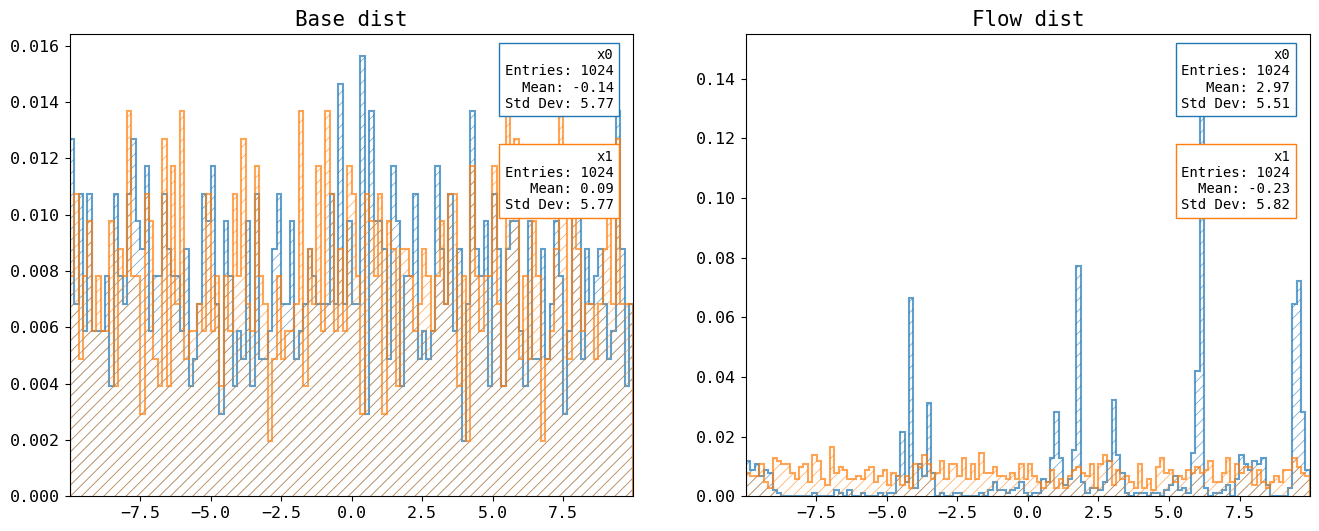

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

plot_proposal(base_dist, ax=axes[0], title='Base dist')
plot_proposal(flow_dist, ax=axes[1], title='Flow dist');

In [54]:
def func(args):
    return torch.exp(-3*torch.sqrt(args.T[0]**2 + args.T[1]**2))
    #return args.T[0]**3 + torch.exp(-10* args.T[1]**2)
    
    # old center: new_width/2
    # new center: (max+min)/2
    
print(f'Uninitalized NF: {get_result(flow_dist, func, n_samples=1000000)}')
print(f'Uniform dist   : {get_result(base_dist, func, n_samples=10000, is_nf=False)}')

Uninitalized NF: (0.7334265112876892, 0.02163366600871086)
Uniform dist   : (0.6496599316596985, 0.07453658431768417)


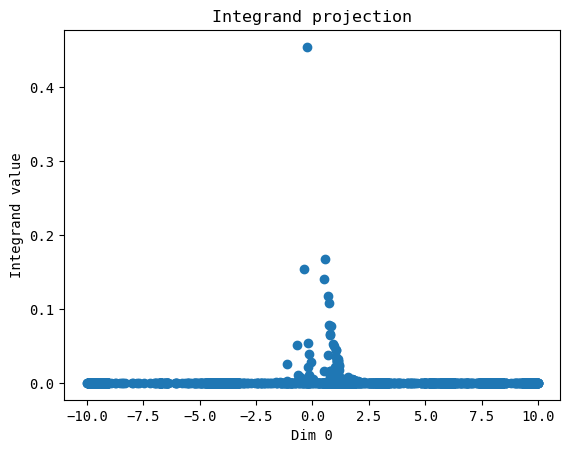

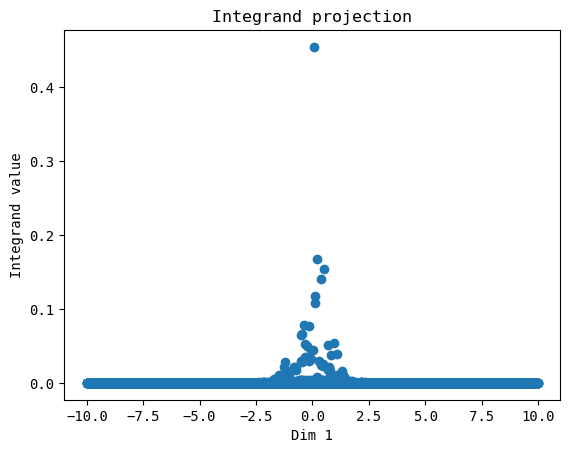

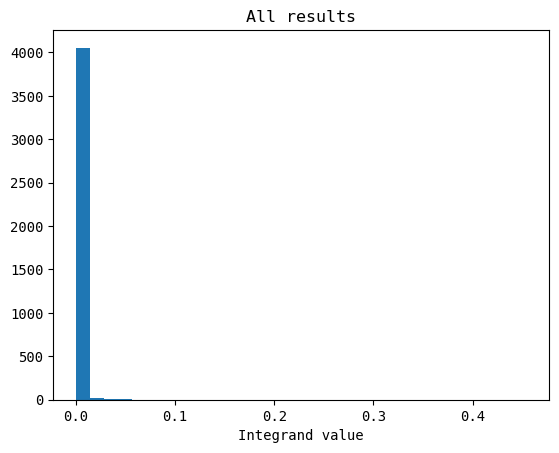

In [55]:
plot_integrand(flow_dist, func, n_samples=4096)

In [56]:
def train_backward(flow_dist, transform, base_dist, func, n_samples:int=32000, n_epochs:int=10):
    optimizer = torch.optim.Adam(transform.parameters(), lr=1e-3)
    p = base_dist.log_prob(torch.tensor([0]*2)).sum().exp().detach()
    
    for i in range(n_epochs):
        optimizer.zero_grad()
        
        base = base_dist.sample([n_samples])
        samples = transform(base)
        log_p = flow_dist.log_prob(base)#.sum(dim=1)
        
        prob = log_p.exp()
        results = func(samples).detach()
        
        loss = (1/n_samples * (1/(p*prob)) * results**2).sum()

        loss.backward()
        optimizer.step()
        
        flow_dist.clear_cache()
        
        if i % 10 == 0:
            print(f"Epoch {i}: {loss.item()}")

In [57]:
#train_iflow(flow_dist, spline_transform, base_dist, func)
train_backward(flow_dist, spline_transform, base_dist, func, n_epochs=100)

Epoch 0: 125.15159606933594
Epoch 10: 61.52300262451172
Epoch 20: 29.934776306152344
Epoch 30: 21.161842346191406
Epoch 40: 13.232941627502441
Epoch 50: 20.63159942626953
Epoch 60: 15.653877258300781
Epoch 70: 22.37460708618164
Epoch 80: 20.15618896484375
Epoch 90: 20.71215057373047


Using inferred bounds -9.992400169372559 to 9.994915008544922
Using inferred bounds -9.952971458435059 to 9.985352516174316


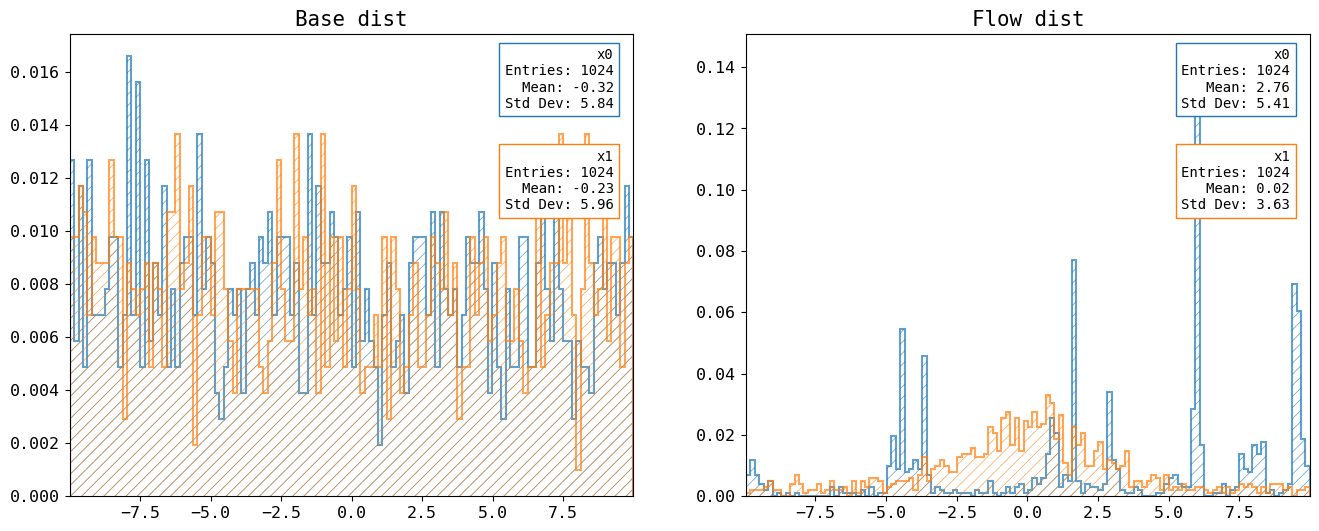

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

plot_proposal(base_dist, ax=axes[0], title='Base dist')
plot_proposal(flow_dist, ax=axes[1], title='Flow dist');

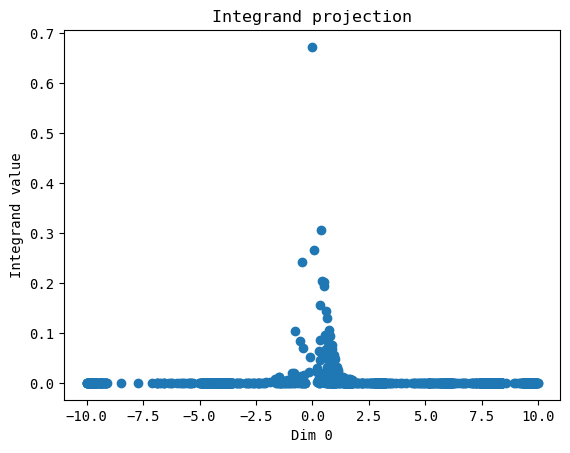

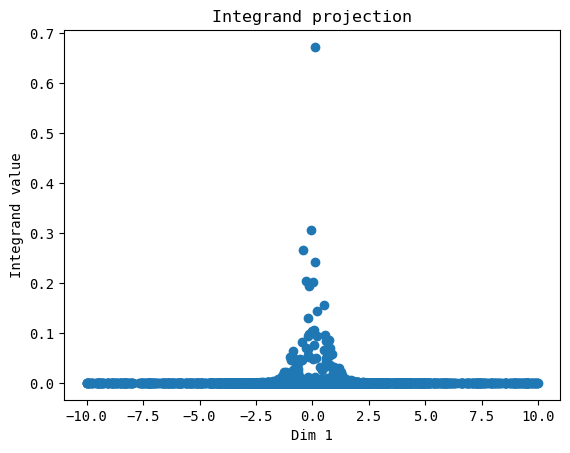

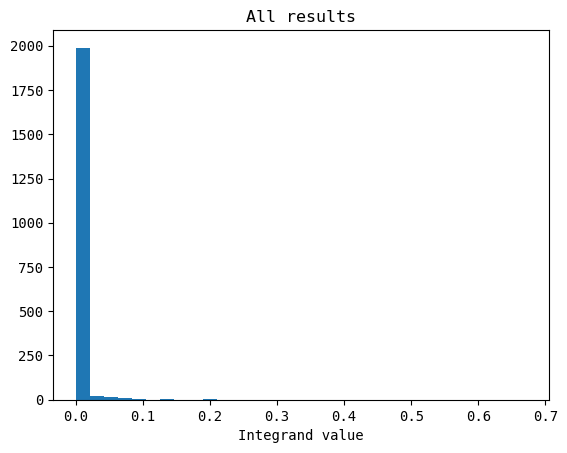

In [59]:
plot_integrand(flow_dist, func, y_log=False)

In [69]:
print("NF     :", get_result(flow_dist, func, n_samples=4096))
print("Uniform:", get_result(base_dist, func, n_samples=4096, is_nf=False))

NF     : (0.8418370485305786, 0.1771736592054367)
Uniform: (1.1338541507720947, 0.18585853278636932)
